In [12]:
%matplotlib notebook

In [11]:
from microphone import record_audio
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from IPython.display import Audio
import librosa

from numba import njit
import numpy as np
import pickle
import time

from music21 import *
import pygame as pg

from sklearn.cluster import KMeans

pygame 2.1.2 (SDL 2.0.16, Python 3.8.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [13]:
us = environment.UserSettings()
us.getSettingsPath()
environment.set('musescoreDirectPNGPath', "/usr/bin/musescore")

Getting User Input

In [52]:
def micRecord(time=10):
    frames, rate = record_audio(time)
    return np.hstack([np.frombuffer(i, np.int16) for i in frames]), rate
def getFile(path):
    recorded_audio, sampling_rate = librosa.load(path, 
                                                 sr=44100, 
                                                 mono=True,
                                                duration=33)
    return recorded_audio, sampling_rate
def pressure(times: np.ndarray, *, amp: float, freq: float) -> np.ndarray:
    return amp * np.sin(2 * np.pi * freq * times)
def pureTone(freq, amp=0.06, dur=3, rate=44100):
    n_samples = int(dur * rate) + 1
    times = np.arange(n_samples) / rate  # seconds
    return pressure(times, amp=amp, freq=freq), rate  # Pascals

In [15]:
def userinput():
    while True:
        audioType = input("u for Upload, r for Record: ")
        if audioType == 'u':
            path = input("Enter path to file: ")
            samples, rate = getFile(path)
            break
        elif audioType == 'r':
            samples, rate = micRecord()
            break
        print("Invalid input. Try again.")
    # print(rate)
    
    return samples, rate

Processing

In [16]:
def getspec(samples, rate):
    spectrogram, freqs, times = mlab.specgram(
		samples,
		NFFT=4096,
		Fs=rate,
		window=mlab.window_hanning,
		noverlap=int(4096 / 2)
	)
    return spectrogram, freqs, times

In [17]:
def distinctFreqs(freq1:float, freq2:float, a=1.059):
    larger_freq = max(freq1, freq2)
    smaller_freq = min(freq1, freq2)
    if smaller_freq == 0:
        smaller_freq = 1e-100
    if larger_freq/smaller_freq >= a:
        return True
    else:
        return False

In [41]:
def convert(freqTimes):
    freqDurations = []
    freqTimes = list(freqTimes.values())
    freqTimes.append(0)
    
    time=0
    curlength=0
    curnote=0
    while time<len(freqTimes):
        if distinctFreqs(freqTimes[time], curnote):
            if curnote!=0 and curlength>2:
                freqDurations.append([curnote, time-curlength, curlength])
                curlength = 0
                curnote = freqTimes[time]
            elif curnote==0 and curlength>2:
                curlength = 0
                curnote = freqTimes[time]
            elif not distinctFreqs(freqTimes[time], freqDurations[-1][0]):
                curnote = freqDurations[-1][0]
            else:
                curlength = 0
                curnote = freqTimes[time]
        else:
            curlength+=1
        time+=1
    return freqDurations

In [45]:
conversion = {
    pitch.Accidental("sharp"):pitch.Accidental("sharp"),
    pitch.Accidental("half-sharp"):None,
    pitch.Accidental("one-and-a-half-sharp"):pitch.Accidental("sharp"),
    None:None
}

def notes(freqDurations: list):
    #return list of notes
    #normFreqs = music21.audioSearch.detectPitchFrequencies([freq[0] for freq in freqDurs])
    notes = []
    duration_list = [0.166, 0.5, 1, 2, 4]
    
    for freqIndex in range(len(freqDurations)):
        p = pitch.Pitch()
        p.frequency = freqDurations[freqIndex][0]
        p.accidental = conversion[p.accidental]
        n = note.Note(pitchName = p.name)
        d = duration.Duration()
        d.quarterLength = duration_list[2]
        n.duration = d
        notes.append(n)
    #print(normFreqs)
    return notes

In [22]:
def streamNotes(notes: list):
    s = stream.Stream()
    for n in notes:
        s.append(n)
#     mf = midi.translate.streamToMidiFile(s)
    s.show()
    #sp = midi.realtime.StreamPlayer(s, playForMilliseconds = 5000)
    #sp.play()
#     return mf

In [50]:
def sheetMusic(peak_dict: dict, num_clusters: int):
    freqDurs = convert(peak_dict)
    
    notesList = notes(freqDurs)
    streamNotes(notesList)

In [24]:
def find_min_amp(maxamps, amp_threshold):
    ind = round(len(maxamps) * amp_threshold)
    cutoff_log_amplitude = np.partition(maxamps, ind)[ind]
    return cutoff_log_amplitude

u for Upload, r for Record: u
Enter path to file: twinkle.mp3


/home/alanxw/miniconda3/envs/week1/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


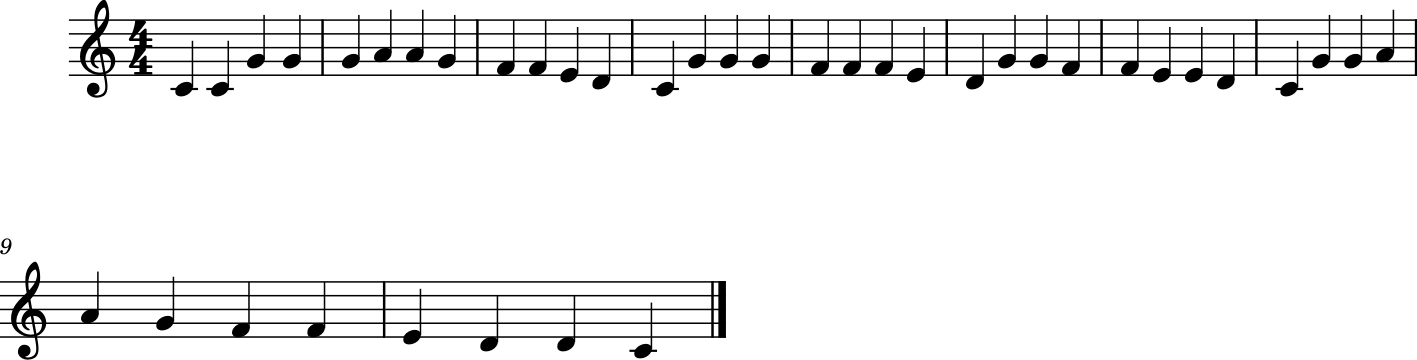

In [53]:
#music, sampling_rate = pureTone(261.63)
music, sampling_rate = userinput()
spec, freq, time = getspec(music, sampling_rate)

maxamps = np.log(np.max(spec,axis=0))
maxfreqs = np.argmax(spec, axis=0)
maxfreqs = freq[maxfreqs]

thresh = find_min_amp(maxamps,0.2)
comps = maxamps>thresh
zeroedfreqs = comps*maxfreqs

timefreq = [(i,j) for i,j in enumerate(zeroedfreqs)]
timefreq = dict(timefreq)

sheetMusic(timefreq, num_clusters = 1)